In [2]:
import cdsapi
import healpy as hp
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
from pathlib import Path
import zarr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#additional packages that are required to run this project are h5netcdf, netcdf4, scipy, zarr

In [3]:
# CONFIG

#====== download config ======#
collection='reanalysis-era5-pressure-levels' #this notebook was only tested for the specified collection

variables=['specific_humidity'] # other variables can be found at https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table9. This notebook was only developed for continues pressure level variables

pressure_levels = [300, 500, 800, 900, 975]

temporal_extend = {
    "start": '2024-12-01',
    "end": '2024-12-03',
    "times": ['00:00:00', '06:00:00', '12:00:00', '18:00:00'],
}

spacial_extend = 'global' #for a limited area provide an array of shape [north, west, south, east]. north, south of range [-90, 90] west, east [-180, 180]

data_format = {"format": 'netcdf', "file_ending": '.nc'} # Downstream Processing requires netcdf so only change this variable if you want to change the processing pipeline

grid_res = ['0.25', '0.25'] # [res_long, res_lat] resolution of the grid for the download. The specified 0.25° are the default resolution for atmospheric data in the ERA5 Dataset

#====== storage config =======#
collection_short_name='era5' #short name used for data_storage
storage_path='../data/'
unprocessed_path=f'{collection_short_name}_regular_grid/'
zarr_file=f'{collection_short_name}_healpix.zarr'
zarr_append_dim='time' #in the current state of this script only time makes sense and is the only dimension tested.

#===== regridding config =====#

nsides = [8, 16]
interpolation_method = 'linear' # methode for the interpolation to healpix (one of "linear", "nearest", "zero", "slinear", "quadratic", "cubic", "quintic", "polynomial")

In [4]:
if not Path(storage_path).exists():
    Path(storage_path).mkdir()

if not Path(storage_path + unprocessed_path).exists():
    Path(storage_path + unprocessed_path).mkdir()


In [5]:
import warnings
from zarr.errors import ZarrUserWarning

warnings.filterwarnings("ignore", category=ZarrUserWarning)

In [6]:
# This cell iterates over the time period defined in temporal_extend and creates a dict containing day month and year for each day in the interval. This will later be used for the main downloading loop
start_date = datetime.strptime(temporal_extend["start"], '%Y-%m-%d')
end_date = datetime.strptime(temporal_extend["end"], '%Y-%m-%d')

time_chunks = []
for delta in range((end_date - start_date).days + 1): # iterate over the date range to create a dict for each day in our time_chunks list. Later we can loop over those list entries to loop over the days
    i_date = start_date + timedelta(days=delta)
    time_chunks.append({
        "day": i_date.day,
        "month": i_date.month,
        "year": i_date.year,
        "string": i_date.strftime("%Y-%m-%d"),
        "timestamp": np.datetime64(i_date)
    })

time_chunks[:3] # :3 needed to limit console size for bigger temporal extends

[{'day': 1,
  'month': 12,
  'year': 2024,
  'string': '2024-12-01',
  'timestamp': np.datetime64('2024-12-01T00:00:00.000000')},
 {'day': 2,
  'month': 12,
  'year': 2024,
  'string': '2024-12-02',
  'timestamp': np.datetime64('2024-12-02T00:00:00.000000')},
 {'day': 3,
  'month': 12,
  'year': 2024,
  'string': '2024-12-03',
  'timestamp': np.datetime64('2024-12-03T00:00:00.000000')}]

In [7]:
# extract the calculations for the healpix grids out of the main routine, so we don't do them multiple times (potentially for a lot of days / nside resolutions, amounting to a lot of calculations)
hp_grids = []

for nside in nsides: # iterate over nside resolutions and create the grid so we don't have to do it multiple tim
    n_pix = hp.nside2npix(nside) # calculate number of pixels
    theta, phi = hp.pix2ang(nside, np.arange(n_pix)) # calculate the pixel centers for each pixel in rad

    hp_latitude = 90 - np.degrees(theta) # convert to degrees (North Pole = 0, South Pole = 180) and subtract from 90 to get to (North Pole = 90, South Pole = -90)
    hp_longitude = np.degrees(phi) # convert to degrees (Greenwich = 0, increasing eastwards)

    hp_grids.append({"latitude": hp_latitude, "longitude": hp_longitude, "name": f'nside-{nside}'})

In [8]:
c = cdsapi.Client()

zarr_path = storage_path + zarr_file

for time_chunk in time_chunks:
    file_name = f'{collection_short_name}_{time_chunk["string"]}'
    complete_path = storage_path + unprocessed_path + file_name + data_format["file_ending"]

    if Path(complete_path).exists():
        print(f'{file_name + data_format["file_ending"]} was already downloaded. Skipping download...')
        try:
            ds = xr.open_dataset(complete_path)
        except:
            print(f'the file {complete_path} appears to be corrupted. Please remove it and try again')
            continue
    else:
        print(f"Downloading {file_name + data_format["file_ending"]}...")
        c.retrieve(collection, {
            "product_type": ['reanalysis'],
            "variable": variables,
            "year": time_chunk["year"],
            "month": time_chunk["month"],
            "day": time_chunk["day"],
            "time": temporal_extend["times"],
            "pressure_level": pressure_levels,
            "grid": grid_res,
            "area": spacial_extend,
           "data_format": data_format["format"],
        }, complete_path)
        print(f"Download completed")
        ds = xr.open_dataset(complete_path)

    ds = ds.sortby("latitude")

    zarr_root = zarr.open_group(zarr_path, mode="a") if Path(zarr_path).exists() else None #Only read zarr_root once per processed day -> no unnecessary metadata reads

    for hp_grid in hp_grids:
        group_path = hp_grid["name"]
        ds_existing = None
        if zarr_root is not None and group_path in zarr_root.group_keys():
            ds_existing = xr.open_zarr(zarr_path, group=group_path)

        dimension_exists = ds_existing is not None and zarr_append_dim in ds_existing.dims and ds_existing.sizes[zarr_append_dim] > 0

        if (
            dimension_exists
            and time_chunk["timestamp"] in ds_existing[zarr_append_dim].to_index()
        ):
            print(f'{file_name} in resolution {hp_grid["name"]} already exists. Skipping interpolation...')
            continue

        print(f"Interpolating {file_name} in resolution {hp_grid["name"]}")

        ds_hp = ds.interp(
            latitude=xr.DataArray(hp_grid["latitude"], dims='pix'),
            longitude=xr.DataArray(hp_grid["longitude"], dims='pix'),
            method=interpolation_method
        )

        ds_hp = ds_hp.rename({"valid_time": 'time', "pressure_level": 'level'}) # rename to be more tsar_standard
        ds_hp = ds_hp.assign_coords(pix=("pix", np.arange(ds_hp.sizes["pix"], dtype=np.int64)))
        ds_hp = ds_hp.assign_coords(level=ds_hp["level"].astype(np.int32))
        ds_hp = ds_hp.drop_vars(["expver", "number"], errors="ignore") #drop unnecessary variables


        if (
            dimension_exists
        ):
            print(f'Group {group_path} of archive {zarr_file} is not empty. Appending...')
            ds_hp.to_zarr(zarr_path, group=group_path, mode="a", append_dim=zarr_append_dim)
            continue

        print(f'Group {group_path} of archive {zarr_file} does not exists or is empty. Creating / Writing...')
        ds_hp.to_zarr(zarr_path, group=group_path, mode="w")

    print(f'Processing of {collection_short_name}_{time_chunk["string"]} completed.')

era5_2024-12-01.nc was already downloaded. Skipping download...
era5_2024-12-01 in resolution nside-8 already exists. Skipping interpolation...
era5_2024-12-01 in resolution nside-16 already exists. Skipping interpolation...
Processing of era5_2024-12-01 completed.
era5_2024-12-02.nc was already downloaded. Skipping download...
era5_2024-12-02 in resolution nside-8 already exists. Skipping interpolation...
era5_2024-12-02 in resolution nside-16 already exists. Skipping interpolation...
Processing of era5_2024-12-02 completed.
era5_2024-12-03.nc was already downloaded. Skipping download...
era5_2024-12-03 in resolution nside-8 already exists. Skipping interpolation...
era5_2024-12-03 in resolution nside-16 already exists. Skipping interpolation...
Processing of era5_2024-12-03 completed.


In [9]:
from scipy.interpolate import griddata

def pix_to_grid_interp(da_pix, lat_name="latitude", lon_name="longitude", nlat=360, nlon=720):
    lats = da_pix[lat_name].values
    lons = da_pix[lon_name].values
    lons = ((lons + 180) % 360) - 180

    points = np.column_stack([lons, lats])
    values = da_pix.values

    lon_grid = np.linspace(-180, 180, nlon)
    lat_grid = np.linspace(-90, 90, nlat)
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

    out = griddata(
        points,
        values,
        (lon2d, lat2d),
        method="linear"
    )

    return xr.DataArray(
        out,
        dims=("lat", "lon"),
        coords={"lat": lat_grid, "lon": lon_grid},
        name=da_pix.name
    )

Text(0.5, 1.05, 'Specific humidity at 975 hPa')

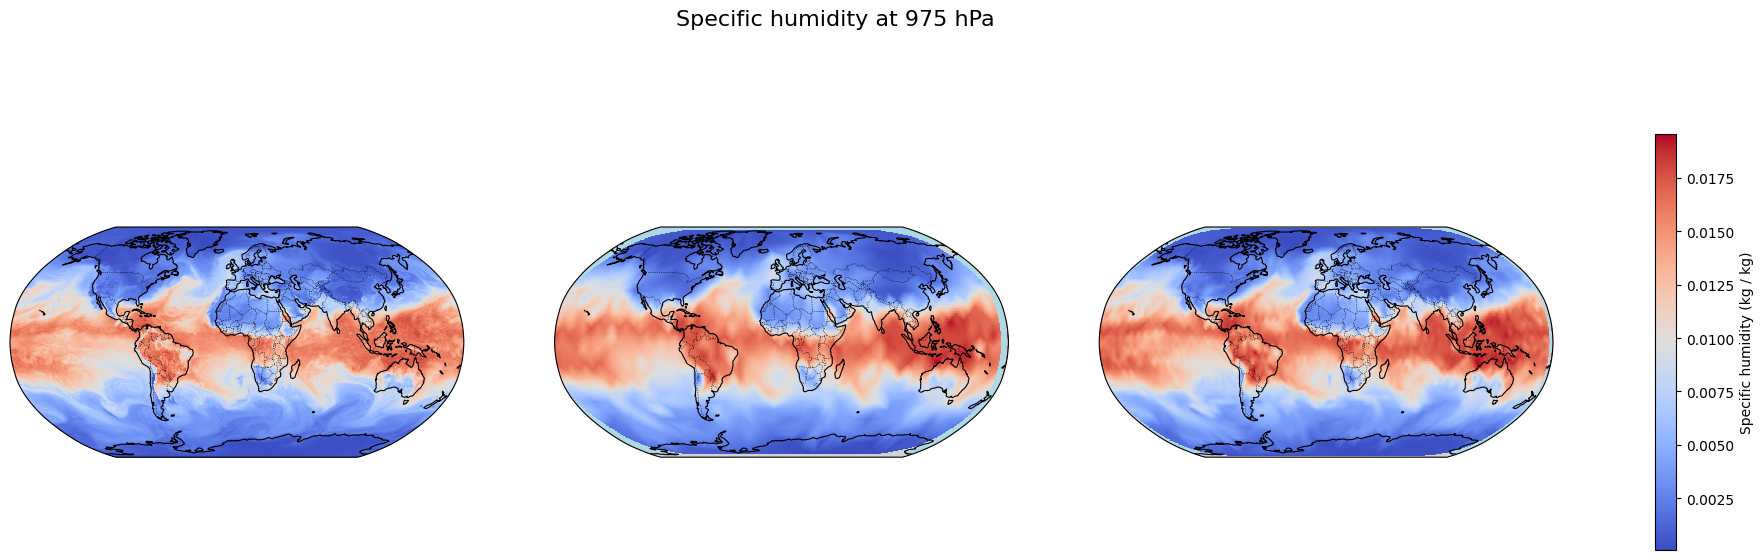

In [10]:
%matplotlib inline
# and produce a simple plot of the 1000 hPa temperature field


# Select data for pressure level 1000 hPa (index 0, since pressure_level[0] = 1000.0)
# and valid_time on April 3, 2021 at 00:00
dates=['2024-12-01T00:00:00', '2024-12-01T00:00:00']
timestamp=dates[0]
file_name = f'{collection_short_name}_{timestamp.split("T")[0]}'
path = complete_path = storage_path + unprocessed_path + file_name + data_format["file_ending"]

ds_unprocessed = xr.open_dataset(complete_path)
ds_processed_0 = xr.open_zarr(zarr_path, group=hp_grids[0]["name"])
ds_processed_1 = xr.open_zarr(zarr_path, group=hp_grids[1]["name"])

a_unprocessed = ds_unprocessed['q'].sel(pressure_level=975, valid_time=ds_unprocessed['valid_time'][0])
a_processed_0 = pix_to_grid_interp(ds_processed_0['q'].sel(level=975,time=timestamp))
a_processed_1 = pix_to_grid_interp(ds_processed_1['q'].sel(level=975,time=timestamp))

t_data = [a_unprocessed, a_processed_0, a_processed_1]

# Create the plot with Robinson projection
fig, ax = plt.subplots(ncols=3, figsize=(22, 6), subplot_kw={"projection": ccrs.Robinson()})

mappable = None

for i in range(3):
    # Plot the temperature field
    mappable = t_data[i].plot(
        ax=ax[i],
        transform=ccrs.PlateCarree(),  # Data is in PlateCarree (lon/lat)
        cmap='coolwarm',
        add_colorbar=False,
        add_labels=False  # Avoid duplicate labels
    )

    # Add coastlines and country borders
    ax[i].add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax[i].add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax[i].add_feature(cfeature.LAND, color='lightgray')
    ax[i].add_feature(cfeature.OCEAN, color='lightblue')

    # add one colorbar for all plots
cbar = fig.colorbar(
    mappable,
    ax=ax,
    orientation="vertical",
    fraction=0.035,  # thinner bar
    pad=0.06,        # <-- key: push it away from the plots
    shrink=0.9
)
cbar.set_label("Specific humidity (kg / kg)")
fig.suptitle("Specific humidity at 975 hPa", fontsize=16, y=1.05)
# Improve layout